# 1. Подготовка

In [1]:
#импорт необходимых библиотек
import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [2]:
#загрузка данных
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
#проверка данных
display(data.head(10))
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
#ресемплирование данных по часам
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [5]:
#проверка данных
display(data.head(10))
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


### Выводы. Шаг 1
1) Первичный анализ данных показал, что в таблице отсутсвуют пустые значения.   
2) Проведено ресемплирование данных по часам.  


# 2. Анализ

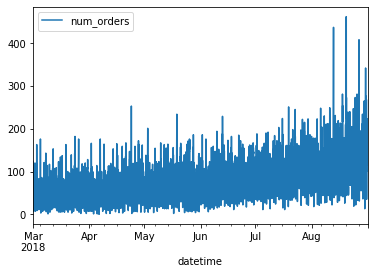

In [6]:
#построение графика по часам
data.plot()

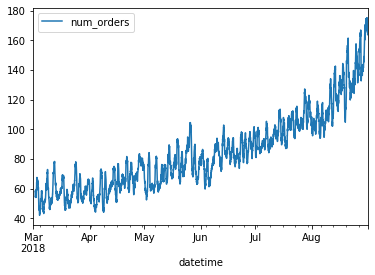

In [7]:
#построение графика со скользящей средней по часам
data_mean = data.rolling(25).mean()
data_mean.plot()

Text(0.5, 1.0, 'Seasonality')

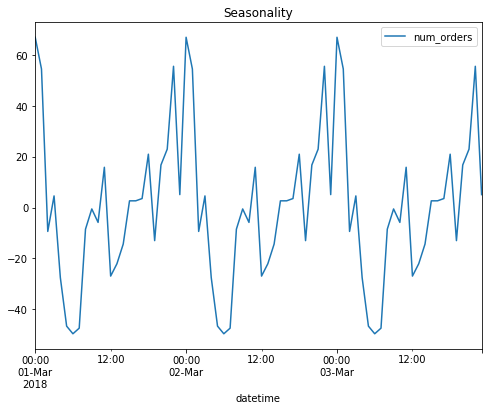

In [8]:
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-03'])

plt.figure(figsize=(8, 6))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Text(0.5, 1.0, 'Trend')

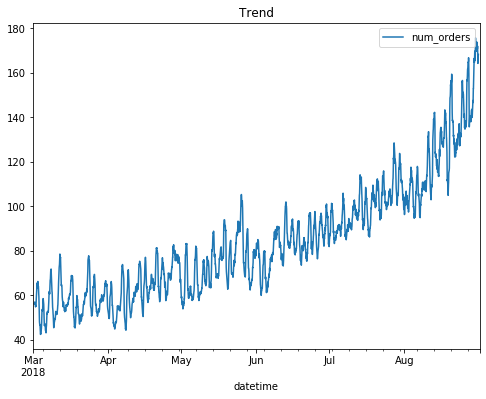

In [9]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(8, 6))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

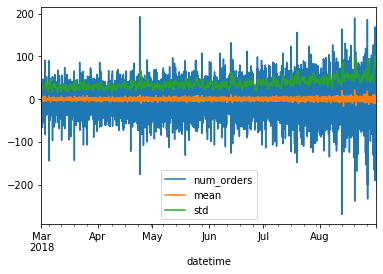

In [10]:
#разности временного ряда
data_raz = data - data.shift()
data_raz['mean'] = data_raz['num_orders'].rolling(20).mean()
data_raz['std'] = data_raz['num_orders'].rolling(20).std()
data_raz.plot()

### Выводы. Шаг 2
1) Ряд получается стационарный, так как среднее и стандартное отклоение не меняются - можно сказать они на всем протяжении находятся в ранвхы диапазонах. Можно строить прогноз).  
2) Что касаемо сезонности, из графика видно, что спрос на такси повышается каждый день в интервале с 18 и до 24 часов.   
3) Общий тренд - постепенное увеличение кол-ва заказов такси от начала к концу лета, скорей всего связано с тем, что многие возращаются из отпусков. Чтобы ответить со стопроцентной уверенность, нужно больше данных.  


# 3. Обучение

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [12]:
make_features(data, 24, 3)
data = data.fillna(0)

In [13]:
display(data.head(10))

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2018-03-01 01:00:00,85,2018,3,1,3,124.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.333333
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.000000
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,85.0,124.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.000000
2018-03-01 06:00:00,12,2018,3,1,3,6.0,43.0,66.0,71.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.333333
2018-03-01 07:00:00,15,2018,3,1,3,12.0,6.0,43.0,66.0,71.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.333333
2018-03-01 08:00:00,34,2018,3,1,3,15.0,12.0,6.0,43.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.000000


In [14]:
#подготовка валидационной и обучающей выборки
train, valid = train_test_split(data, test_size=0.1, shuffle=False)

In [15]:
#проверка деления на валидационную и обучающую выборки
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [16]:
features_train = train.drop(['num_orders'], axis = 1)
features_valid = valid.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
target_valid = valid['num_orders']

In [17]:
def rmse(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    return rmse

In [18]:
#определение критерия по оценки модели
my_scorer = make_scorer(rmse, greater_is_better=False)
my_cv = TimeSeriesSplit(n_splits=3)

In [19]:
#определение гипепараметров для модели "случайный лес"
#model_for = RandomForestRegressor()

#parametrs = {'max_depth': range(1,8), 'n_estimators': range(1, 21, 3)}
#grid_search = GridSearchCV(model_for, parametrs, cv=my_cv, scoring = my_scorer)
#grid_search.fit(features_train, target_train)
#grid_search.best_params_

{'max_depth': 7, 'n_estimators': 19}

In [20]:
#определение гипепараметров для модели "дерево решений"
#model_tree = DecisionTreeRegressor()

#parametrs = {'max_depth': range(1,8), 'min_samples_split': range(2, 8)}
#grid_search = GridSearchCV(model_tree, parametrs, cv=my_cv, scoring = my_scorer)
#grid_search.fit(features_train, target_train)
#grid_search.best_params_

{'max_depth': 4, 'min_samples_split': 2}

In [21]:
#определение гипепараметров для модели "LGB"
#model_lgb = LGBMRegressor(boosting_type ='gbdt')

#parametrs = {'max_depth': range(1,3), 'num_leaves': range(31, 93, 31)}
#grid_search = GridSearchCV(model_lgb, parametrs, cv=my_cv, scoring = my_scorer)
#grid_search.fit(features_train, target_train)
#grid_search.best_params_

{'max_depth': 2, 'num_leaves': 31}

### Выводы. Шаг 3
1) Написана формула разделения даты на день недели, месяц и день. Так же форму находится скольящее среднее.   
2) Таблица разделена на валидационную и обучающую выборку, как сказано в задании на обучающую отводится 10 процентов данных.   
3) Для моделей: случайный лес, дерево решений и lgb найдены гиперпараметры (код поиска закомменитировал так как много времени занимает).    
4) Руками подобраны параметры для фукции make_features, итого получилось: 24 и 3.   

# 4. Тестирование

In [27]:
#обучение модели "Случайный лес"
model_for = RandomForestRegressor(max_depth=7, n_estimators=19)
cross_for = cross_val_score(model_for, features_train, target_train, cv=my_cv, scoring = my_scorer)
print('Значение RMSE для случайного леса (обучающие данные)', "%.2f" % cross_for.mean())

#предсказание модели "Случайный лес"
model_for.fit(features_train, target_train)
predict_for = model_for.predict(features_valid)
print('Значение RMSE для случайного леса (валидационные данные)', "%.2f" % rmse(predict_for, target_valid))

Значение RMSE для случайного леса (обучающие данные) -28.48
Значение RMSE для случайного леса (валидационные данные) 45.98


In [23]:
#обучение модели "Дерево решений"
model_tree = DecisionTreeRegressor(max_depth=4, min_samples_split=2)
cross_tree = cross_val_score(model_tree, features_train, target_train, cv=my_cv, scoring = my_scorer)
print('Значение RMSE для дерева решений (обучающие данные)', "%.2f" % cross_tree.mean())

#предсказание модели "Дерево решений"
model_tree.fit(features_train, target_train)
predict_tree = model_tree.predict(features_valid)
print('Значение RMSE для случайного леса (валидационные данные)', "%.2f" % rmse(predict_tree, target_valid))

Значение RMSE для дерева решений (обучающие данные) -31.06
Значение RMSE для случайного леса (валидационные данные) 52.77


In [24]:
#обучение модели "Линейная регрессия"
model_log = LinearRegression()
cross_log = cross_val_score(model_log, features_train, target_train, cv=my_cv, scoring = my_scorer)
print('Значение RMSE для линейной регрессии (обучающие данные)', "%.2f" % cross_log.mean())

#предсказания модели "Линейная регрессия"
model_log.fit(features_train, target_train)
predict_log = model_log.predict(features_valid)
print('Значение RMSE для линейной регрессии (валидационные данные)', "%.2f" % rmse(predict_log, target_valid))

Значение RMSE для линейной регрессии (обучающие данные) -27.89
Значение RMSE для линейной регрессии (валидационные данные) 45.83


In [25]:
#обучение модели "LGB"
model_lgb = LGBMRegressor(boosting_type ='gbdt', max_depth=2, num_leaves=31)
cross_lgb = cross_val_score(model_lgb, features_train, target_train, cv=my_cv, scoring = my_scorer)
print('Значение RMSE для LGB (обучающие данные)', "%.2f" % cross_lgb.mean())

#предсказания модели "LGB"
model_lgb.fit(features_train, target_train)
predict_lgb = model_lgb.predict(features_valid)
print('Значение RMSE для LGB (валидационные данные)', "%.2f" % rmse(predict_lgb, target_valid))

Значение RMSE для LGB (обучающие данные) -27.57
Значение RMSE для LGB (валидационные данные) 44.68


In [28]:
#таблица с общими результатами
ml = ['Случайный лес', 'Дерево решений', 'Линейная регрессия', 'LGB']
data = {
  'Результаты RMSE на обучающих данных': [cross_for.mean(), cross_tree.mean(), cross_log.mean(), cross_lgb.mean()],
  'Результаты RMSE на валидационных данных':  [rmse(predict_for, target_valid), rmse(predict_tree, target_valid), rmse(predict_log, target_valid), rmse(predict_lgb, target_valid)]
}
data_ml = pd.DataFrame(data=data, index=ml)
display(data_ml)

,Результаты RMSE на обучающих данных,Результаты RMSE на валидационных данных
Случайный лес,-28.480420,45.975976
Дерево решений,-31.061736,52.772920
Линейная регрессия,-27.887979,45.832501
LGB,-27.570731,44.678083


### Выводы. Шаг 4
1) Проведено обучение по 4 моделям: случайный лес, дерево решений, линейная регрессия, lgb. Гиперпараметры были найдены в предыдущем шаге.   
2) Таблица с результатами RMSE получена на последнем шаге - все лучше себя показала модель: Lgb. Показатель RMSE составил - 44,67

### Выводы. Общий вывод по проекту
1) Провели анализ данных с кол-вом заказов такси за период с 1 марта по 31 августа 2018 года.   
2) Для анализа был проведен ресемплинг данных по 1 часу (первоначальные данные были в интервале 10 минут).   
3) В данных наблюдается сезонность в каждом из дней, сезонность заключается в увеличении кол-ва заказов в период с 18 до 24 часов.   
4) Насчет наличия тренда сказать сложно, так как по данным наблюадется постепенное увеличение кол-ва заказов, чтобы дать точную оценку наличия тренда - необходимо получить данные за больший период. По тем данным которые у нас есть - можно сказать, что виден тренд увеличения заказов.   
5) Для обучения модели был найден лаг для 24 предыдущих параметро и с параметром скользящих средних - 3.     
6) Всех лучше себя показала модель - LGB, с показателем RMSE равным 44,67